In [21]:
import numpy as np
import numpy.linalg as lin
import networkx as nx
import scipy
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency 

# Spectral norm from degree sequences
In this notebook we demonstrate experimently that given a random Erdos-Renyi graph G, if we create a new graph that only using the in-degree and out-degree of every node then the spectral norm of this graph is will be clustered around the spectral norm of G with very tight variance

# Prelimaries 
First we implement the powerIteration method in order to quickly estimate the largest eigenvalue

In [22]:
def powerIteration(A, iters=500):
    n = A.shape[0]
    b = np.random.randn(n,)
    b = b / lin.norm(b, ord=2)
    for i in range(iters):
        bnew = A @ b
        b = bnew / lin.norm(bnew, ord = 2)
    return b

def snorm(A):
    b = powerIteration(A.T @ A)
    return np.sqrt((b.T @ A.T @ A @ b))

In [23]:
b = np.zeros((3,2))
b[0,:] = [1,2]
b[1,:] = [3,4]
b[2,:] = [5,6]
snorm(b)

9.52551809156511

## Parameter Setup

Here we set some parameters: the number of nodes, the probability of link formation, and the the number of trials to generate. The way this experiment works is that we first generate a random graph with the specificied n and p, extract the in degree and out degree information, and generate new graphs exact(or as exact as possible) with the same degree sequence. The hypothesis is that knowing the exact degree information is more informatin than knowing just the degree sequence. 

In [73]:
n = 2000

p1 = 2*np.log(n)/n
p2 = 1/n
steps = 30
delta = (p1-p2)/steps
Ps = [p2 + i*delta for i in range(steps)]
n_trials = 250
ones = np.ones((n,))
I = np.eye(n,n)
rho = 0.9


Below is the function used to create Erdos Renyi graphs and the assoicated guesses. 

In [74]:
def ERfactory(n, p, n_trials):
    G = nx.generators.fast_gnp_random_graph(n,p,directed=True)
    A = nx.adj_matrix(G)
    sequence_in = [d for n,d in G.in_degree()]
    sequence_out = [d for n,d in G.out_degree()]
    guesses = []
    for i in range(n_trials):
        guess = nx.adj_matrix(
            nx.directed_configuration_model(sequence_in, sequence_out, create_using=nx.DiGraph)
        )
        guesses.append(guess)
    return [G, A, guesses]

def scaleFactory(n,alpha,n_trials):
    G = nx.generators.scale_free_graph(n)
    A = nx.adj_matrix(G)
    sequence_in = [d for n,d in G.in_degree()]
    sequence_out = [d for n,d in G.out_degree()]
    guesses = []
    for i in range(n_trials):
        guess = nx.adj_matrix(
            nx.directed_configuration_model(sequence_in, sequence_out, create_using=nx.DiGraph)
        )
        guesses.append(guess)
    return [G, A, guesses]    
    

In [75]:
#[Ger, A, guessesER] = ERfactory(n,p, n_trials)
full_trials = [ [ERfactory(n,i, n_trials), i] for i in Ps]


# Optimal Profits
The first experiment is determining what the optimal profit is for G and for each of the guessed graphs. This is assuming that we have full network information but assuming we held the full information for that graph. If the hypothesis is correct then since the degree sequence has a lot of information then the profits shouldn't change by much despite these being different graphs. There are you models, the optimal profit with price discrimation and without and their formulas are  given by

    With price discrimination:     $1^T * (I - 2p/||G+G^T|| G)^{-1} * 1$ 
    
    Without price discrimination:  $1^T * (I - [/||G+G^{T}|| (G+G^{T})^{-1} * 1$
where 1 is the ones vector. 

## Optimal Profit under Uniform pricing
So let's calculate these terms starting with uniform pricing

In [8]:
def profitUniform(A, rho):
    n = A.shape[0]
    alpha = 2*rho/snorm(A + A.T)
    temp = I - alpha* A
    temp = lin.inv(temp)
    return (ones.T @ temp @ ones)[0,0]

guessProfitUniform = [profitUniform(guess, rho) for guess in guessesER]



In [9]:
## actual is just a 1x1 matrix. Access that only element
realProfitUniform = profitUniform(A,rho)
print(realProfitUniform)


7170.681166785545


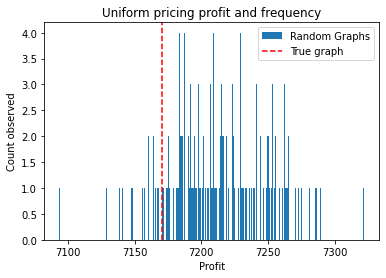

In [13]:
plt.clf()
plt.cla()
plt.close()
histData = np.array(guessProfitUniform)
histData = histData
plt.title("Uniform pricing profit and frequency")
plt.xlabel("Profit")
plt.ylabel("Count observed")
plt.hist(histData, label="Random Graphs", bins=500)
yMax = plt.ylim()[1]
[x0, x1] = plt.xlim()
#x0 = min(x0, hProfitUniform) - 2
#x1 = max(x1, hProfitUniform) + 2
plt.axis([x0, x1, 0, yMax])
plt.vlines(realProfitUniform, color="red",linestyles="dashed", ymin=0, ymax=yMax, label="True graph")
#plt.vlines(hProfitUniform, color="green", linestyles="dashed", ymin=0, ymax=yMax, label="H graph")
plt.legend();
#plt.savefig("uniform.png")

# Notes
Run a chi-test and do more extensive testing
Compare vector differences($\ell_1, \ell_2$) 

Look at power-law

Look at different degree prob. Esp 1/n

Look at "foward error" for profit under G's optimal with guessed graph

Lots trial graphs, plot variance against p

In [16]:
print("Under uniform pricing")
print("Average of guess", np.average(guessProfitUniform))
print("Actual profit", realProfitUniform)
print("Relative Error between guess average and actual profit", abs(realProfitUniform -np.average(guessProfitUniform))/realProfitUniform)



Under uniform pricing
Average of guess 7212.61814087162
Actual profit 7170.681166785545
Relative Error between guess average and actual profit 0.0058483947494871215


# Without uniform pricing

In [18]:
rho = 0.9
def profitDiscrim(A, rho):
    n = A.shape[0]
    alpha = rho / snorm(A + A.T)
    inner = I - alpha*(A + A.T)
    return (ones.T @ lin.inv(inner) @ ones)[0,0]
trueProfit = profitDiscrim(A, rho)
guessedProfit = [ profitDiscrim(g, rho) for g in guessesER]

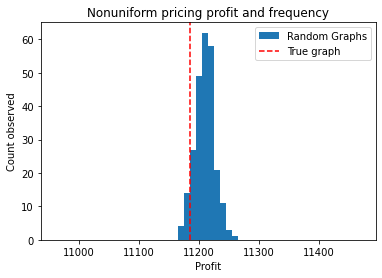

In [19]:
histData = np.array(guessedProfit)
histData = histData
plt.title("Nonuniform pricing profit and frequency")
plt.xlabel("Profit")
plt.ylabel("Count observed")
plt.hist(histData, label="Random Graphs")
yMax = plt.ylim()[1]
[x0, x1] = plt.xlim()
x0 = min(x0, trueProfit) * .98
x1 = max(x1, trueProfit) * 1.02
plt.axis([x0, x1, 0, yMax])
plt.vlines(trueProfit, color="red",linestyles="dashed", ymin=0, ymax=yMax, label="True graph")
#plt.vlines(hProfitDiscrim, color="green", linestyles="dashed", ymin=0, ymax=yMax, label="H graph")
plt.legend();

In [20]:
def chi2(E, O):
    arr = sum( [(sample - E)**2 for sample in O])
    return arr/E

chi2(trueProfit, guessedProfit)

18.645200949708936

In [296]:
print("Under non-uniform pricing")
print("Average of guess", np.average(guessedProfit))
print("Actual profit", trueProfit)
print("Relative Error between guess average and actual profit", abs(trueProfit-np.average(guessedProfit))/trueProfit)

Under non-uniform pricing
Average of guess 4399.619316709874
Actual profit 2284.294582535076
Relative Error between guess average and actual profit 0.9260297469283675


# What Next
We have shown experimently that for both the optimal price with and without discrimation, knowing the exact degree sequence has a much tighter variance than the original graph versus a random graph with the same distribution. 

But what we would really love to see is the optimal price vector also doesn't change by too much. Alternatively as Jiali suggested are there pricing policies that perform well enough for any graph with the same degree sequence. 

## How the optimal price vectors change

In [54]:
def priceVector(rho, A,a,c ):
    n = A.shape[0]
    
    ident = np.eye(n,n)
    ones = np.ones((n,1))
    ApA = A + A.T
    eig = snorm(ApA)
    alpha = rho / eig
    central = lin.inv(ident - alpha*ApA) @ ones
    dif = A - A.T
    return ((a+c)/2)*ones +  ((a-c)*alpha/2) * dif @ central
    #return alpha * dif @ central 

def applyPriceVector(A, rho, v, a, c):
    n = A.shape[0]
    ident = np.eye(n,n)
    ones = np.ones((n,1))
    ApA = A + A.T
    consumption = (2*rho/snorm(ApA)) * A
    consumption = 0.5 * lin.inv(ident - consumption)
    consumption = consumption @ (a*ones - v)
    return ((v - c*ones).T @ consumption)[0,0]

In [83]:
a = 4
c= 2
rho = 0.9 
def averageGap(A, tests, rho, a, c):
    optimalVector = priceVector(rho, A, a, c)
    profitatGuess = [applyPriceVector(g, rho, optimalVector, a,c) for g in tests]
    trueProfit = applyPriceVector(A, rho, optimalVector, a,c)
    return [trueProfit - np.average(profitatGuess)]

def averageGapReverse(A,tests, rho, a,c):
    profitWithGuess = [applyPriceVector(A, rho, priceVector(rho,i, a,c), a,c) for i in tests]
    trueProfit = applyPriceVector(A, rho, priceVector(rho,A,a,c), a, c)
    return trueProfit - np.average(profitWithGuess)

In [63]:
gap_stats = [averageGap(full_trials[i][0][1], full_trials[i][0][2],rho, a, c)  for i in range(steps)]


In [ ]:
gap2_stats = [averageGapReverse(full_trials[i][0][1], full_trials[i][0][2], rho, a,c) for i in range(steps)]

In [ ]:
gaps = [i[0] for i in gap_stats]
plt.title("Average profit gap vs p")
plt.xlabel("p")
plt.ylabel("Gap")
plt.plot(Ps, gaps, label="Gap Size")
plt.legend()

NameError: name 'profit' is not defined

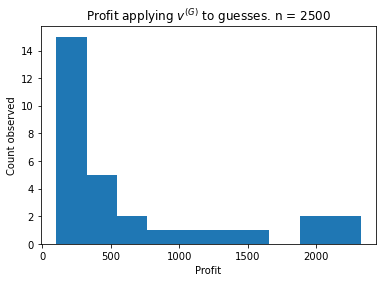

In [78]:
histData = np.array(gaps)
#histData = histData[:,0,0]
plt.title("Profit applying $v^{(G)}$ to guesses. n = 2500")
plt.xlabel("Profit")
plt.ylabel("Count observed")
plt.hist(histData, label="Random Graphs")
yMax = plt.ylim()[1]
[x0, x1] = plt.xlim()
x1 = profit * 1.001
plt.axis([x0, x1, 0, yMax])
plt.vlines(profit, color="red",linestyles="dashed", ymin=0, ymax=yMax, label="True Profit")
plt.legend();
